In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data as Data
import torchvision.datasets
import torchvision.transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from pyampd.ampd import find_peaks


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
PPG_datas = []
ABP_datas = []
ECG_datas = []
i = 0
for name in glob.glob(r'\Users\User\Desktop\dataset\Samples\*.csv'):

    raw_training_data = pd.read_csv(name, header=None)
    raw_training_data.head()
    raw_training_data = np.array(raw_training_data)
    #print(raw_training_data.shape)
    PPG_data = raw_training_data[0].reshape(-1)
    ABP_data = raw_training_data[1].reshape(-1)
    ECG_data = raw_training_data[2].reshape(-1)
    
    PPG_datas.append(PPG_data)
    ABP_datas.append(ABP_data)
    ECG_datas.append(ECG_data)
    i = i + 1
    print(i)
#     if (i == 100):
#         break

PPG_datas = np.array(PPG_datas)
ABP_datas = np.array(ABP_datas)
ECG_datas = np.array(ECG_datas)

print(PPG_datas)
print("OK")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
[array([1.7595, 1.7185, 1.6843, ..., 1.6442, 1.6002, 1.566 ])
 array([2.6901 , 2.6618 , 2.6256 , 2.5816 , 2.5249 , 2.4536 , 2.3675 ,
        2.2708 , 2.1672 , 2.0587 , 1.9521 , 1.8524 , 1.7625 , 1.6843 ,
        1.6246 , 1.5787 , 1.5396 , 1.5083 , 1.4858 , 1.4712 , 1.4633 ,
        1.4585 , 1.4526 , 1.4438 , 1.4301 , 1.4096 , 1.3812 , 1.3539 ,
        1.3265 , 1.2923 , 1.2522 , 1.2111 , 1.1701 , 1.129  , 1.0899 ,
        1.0518 , 1.0176 , 0.98631, 0.95992, 0.9433 , 0.93157, 0.91691,
        0.89932, 0.87879, 0.8563 , 0.83284, 0.81134, 0.79765, 0.80547,
        0.84555, 0.92766, 1.0577 , 1.2043 , 1.3715 , 1.5787 , 1.8006 ,
        2.0186 , 2.2151 , 2.3793 , 2.5044 , 2.5934 , 2.65   , 2.6823 ,
        2.695  , 2.6921 , 2.6794 , 2.6579 , 2.6285 , 2.5904 , 2.5415 ,
        2.4839 , 2.4164 , 2.3412 , 2.26   , 2.173  , 2.0841 , 1.998  ,
        1.9257 , 1.8661 , 1.8113 , 1.7644 , 1.7273 , 1.6999 , 1.6794 ,
  

C:\Users\User\AppData\Local\Temp/ipykernel_15436/273568231.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  PPG_datas = np.array(PPG_datas)
C:\Users\User\AppData\Local\Temp/ipykernel_15436/273568231.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ABP_datas = np.array(ABP_datas)
C:\Users\User\AppData\Local\Temp/ipykernel_15436/273568231.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

In [5]:
def generate_whole_based_vector(X):
    vector = np.zeros(4 * SAMPLE_FREQ)
    vector[:len(X)] = X
    return vector
    
SAMPLE_FREQ = 125
EPOCHS = 2
LR = 0.001

In [6]:
#generate dataset
whole_based_vectors = []
SBP_data = []
DBP_data = []
MAP_data = []

for j in range(len(PPG_datas)):
    sec_15 = 15*SAMPLE_FREQ
    PPG_data = PPG_datas[j]
    ABP_data = ABP_datas[j]
    PPG_peaks = find_peaks(PPG_data, scale=SAMPLE_FREQ)
    for i in range(2, PPG_peaks.shape[0]):
        X = PPG_data[PPG_peaks[i-1]:PPG_peaks[i]]
        if(len(X) < SAMPLE_FREQ):
            whole_based_vector = generate_whole_based_vector(X)

            SBP = np.max(ABP_data[PPG_peaks[i-1]:PPG_peaks[i-1]+sec_15])
            DBP = np.min(ABP_data[PPG_peaks[i-1]:PPG_peaks[i-1]+sec_15])
            MAP = SBP/3 + 2*DBP/3

            whole_based_vectors.append(whole_based_vector)
            SBP_data.append(SBP)
            DBP_data.append(DBP)
            MAP_data.append(MAP)

In [7]:
whole_based_vectors = np.array(whole_based_vectors)
SBP_data = np.array(SBP_data)
DBP_data = np.array(DBP_data)
MAP_data = np.array(MAP_data)
print(whole_based_vectors.shape)
print(SBP_data.shape)

(11895, 500)
(11895,)


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=43)
pca_whole_based_vectors = pca.fit_transform(whole_based_vectors)

print(pca_whole_based_vectors.shape)


(11895, 43)


In [9]:
import torch.nn.functional as F

#LSTM-NN module
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.input = nn.Linear(in_features=input_size, out_features=256)
        self.hidden1 = nn.Linear(in_features=256, out_features=512)
        self.hidden2 = nn.Linear(in_features=512, out_features=256)
        self.hidden3 = nn.Linear(in_features=256, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.dropout = nn.Dropout(p=0.2)
        self.activation = lambda X: F.relu(X)
    
    def forward(self, x):
        out = self.input(x)
        out = self.hidden1(self.activation(out))
        out = self.dropout(out)
        out = self.hidden2(self.activation(out))
        out = self.hidden3(self.activation(out))
#         out = self.dropout(out)
        out = self.output(self.activation(out))
        return out
    
    def get_weight(self):
        weight = []
        weight.append(self.input.weight)
        weight.append(self.hidden1.weight)
        weight.append(self.hidden2.weight)
        weight.append(self.hidden3.weight)
        weight.append(self.output.weight)
        return weight

In [21]:
torch.set_default_tensor_type(torch.FloatTensor)

class module():
    def __init__(self, net, train_loader, test_loader, EPOCH=20, LR=0.0001):
        self.net = net
        self.optimizer = torch.optim.Adam(net.parameters(), lr = LR)
        self.criterion = nn.MSELoss()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.EPOCHS = EPOCH
        self.LR = LR

        self.net = self.net.to(device)
        if device == 'cuda':
            # self.net = torch.nn.DataParallel(self.net)
            torch.backends.cudnn.benchmark = True

    def start(self):

        self.history_train_loss = []
        self.history_test_loss = []
#         history_train_accuracy = []
#         history_test_accuracy = []
        for epoch in range(self.EPOCHS):
            print('Epoch:', epoch)
            train_loss = self.train()
            test_loss = self.test()

            self.history_train_loss.append(train_loss)
            self.history_test_loss.append(test_loss)
#             history_train_accuracy.append(train_accuracy)
#             history_test_accuracy.append(test_accuracy)

    def train(self):
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        for step, (batch_X, batch_y) in enumerate(self.train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self.net(batch_X).double()
            
            loss = self.criterion(outputs.reshape(-1), batch_y)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
        print('【Training】Loss: %.3f ' % ( train_loss))
        return train_loss
    
    def test(self):
        self.net.eval()

        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(self.test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = self.net(batch_X).double()
                loss = self.criterion(outputs.reshape(-1), batch_y)

                test_loss += loss.item()
#                 _, predicted = outputs.max(1)
#                 #print(predicted, batch_y)
#                 total += batch_y.size(0)
#                 correct += predicted.eq(batch_y).sum().item()   

        print('【Testing】Loss: %.3f )' % ( test_loss))
        return test_loss
    
    def predict(self, test_loader):
        outputs = []
        self.net.eval()

        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = self.net(batch_X).double().cpu().numpy().reshape(-1)
                for i in range(len(output)):
                    outputs.append(output[i])
                
        return outputs
    
    def get_weight(self):
        return self.net.get_weight()
    
    def get_model(self):
        return self.net.state_dict()


In [ ]:
#Training

from sklearn.model_selection import train_test_split

L = 43

x_train, x_test, SBP_train, SBP_test, DBP_train, DBP_test, MAP_train, MAP_test = train_test_split(
                                            pca_whole_based_vectors, SBP_data, DBP_data, MAP_data, test_size=0.1, random_state=42)


x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
SBP_train = torch.from_numpy(SBP_train)
SBP_test = torch.from_numpy(SBP_test)
DBP_train = torch.from_numpy(DBP_train)
DBP_test = torch.from_numpy(DBP_test)
MAP_train = torch.from_numpy(MAP_train)
MAP_test = torch.from_numpy(MAP_test)

x_train = x_train.view(-1, 1, L)
x_test = x_test.view(-1, 1, L)

print(x_train.shape, x_test.shape, SBP_train.shape, SBP_test.shape)

SBP_train_dataset = Data.TensorDataset(x_train, SBP_train)
SBP_test_dataset = Data.TensorDataset(x_test, SBP_test)


SBP_train_loader = Data.DataLoader(
    dataset = SBP_train_dataset,
    batch_size = 128,
)


SBP_test_loader = Data.DataLoader(
    dataset = SBP_test_dataset,
    batch_size = 10,
)

DBP_train_dataset = Data.TensorDataset(x_train, DBP_train)
DBP_test_dataset = Data.TensorDataset(x_test, DBP_test)


DBP_train_loader = Data.DataLoader(
    dataset = DBP_train_dataset,
    batch_size = 128,
)

DBP_test_loader = Data.DataLoader(
    dataset = DBP_test_dataset,
    batch_size = 10,
)

MAP_train_dataset = Data.TensorDataset(x_train, MAP_train)
MAP_test_dataset = Data.TensorDataset(x_test, MAP_test)


MAP_train_loader = Data.DataLoader(
    dataset = MAP_train_dataset,
    batch_size = 128,
)

MAP_test_loader = Data.DataLoader(
    dataset = MAP_test_dataset,
    batch_size = 10,
)






In [40]:
def AAMI_standard(predict, test):
    total = len(predict)
    ME = np.mean(predict - test)
    MAE = np.mean(np.abs(predict-test))
    SD = np.std(predict-test)
    
    return total, ME, MAE, SD
    
def BHS_standard(predict, test):
    total = len(predict)
    mm5 = np.sum(np.abs(predict-test)<=5)
    mm10 = np.sum(np.abs(predict-test)<=10)
    mm15 = np.sum(np.abs(predict-test)<=15)
    return total, mm5, mm10, mm15

In [41]:
SBP_nn_module = module(NN(input_size=L), SBP_train_loader, SBP_test_loader, EPOCH=200, LR=LR)
SBP_nn_module.start()

DBP_nn_module = module(NN(input_size=L), DBP_train_loader, DBP_test_loader, EPOCH=200, LR=LR)
DBP_nn_module.start()

MAP_nn_module = module(NN(input_size=L), MAP_train_loader, MAP_test_loader, EPOCH=200, LR=LR)
MAP_nn_module.start()

Epoch: 0
【Training】Loss: 513932.390 
【Testing】Loss: 12554.598 )
Epoch: 1
【Training】Loss: 56580.902 
【Testing】Loss: 10528.468 )
Epoch: 2
【Training】Loss: 49950.370 
【Testing】Loss: 12602.225 )
Epoch: 3
【Training】Loss: 46813.903 
【Testing】Loss: 11119.286 )
Epoch: 4
【Training】Loss: 44590.927 
【Testing】Loss: 8365.865 )
Epoch: 5
【Training】Loss: 42672.938 
【Testing】Loss: 8262.627 )
Epoch: 6
【Training】Loss: 41632.123 
【Testing】Loss: 8054.534 )
Epoch: 7
【Training】Loss: 40154.164 
【Testing】Loss: 7745.003 )
Epoch: 8
【Training】Loss: 40399.340 
【Testing】Loss: 7658.417 )
Epoch: 9
【Training】Loss: 38474.074 
【Testing】Loss: 7577.548 )
Epoch: 10
【Training】Loss: 37543.209 
【Testing】Loss: 8972.785 )
Epoch: 11
【Training】Loss: 37676.658 
【Testing】Loss: 7393.017 )
Epoch: 12
【Training】Loss: 35625.439 
【Testing】Loss: 7735.787 )
Epoch: 13
【Training】Loss: 35447.497 
【Testing】Loss: 6862.901 )
Epoch: 14
【Training】Loss: 35146.637 
【Testing】Loss: 8548.910 )
Epoch: 15
【Training】Loss: 34263.925 
【Testing】Loss: 6943.365

In [43]:
SBP_predict = np.array(SBP_nn_module.predict(SBP_test_loader)).reshape(-1)
SBP_test = np.array(SBP_test)
DBP_predict = np.array(DBP_nn_module.predict(DBP_test_loader)).reshape(-1)
DBP_test = np.array(DBP_test)
MAP_predict = np.array(MAP_nn_module.predict(MAP_test_loader)).reshape(-1)
MAP_test = np.array(MAP_test)

print('Fully Connected Nueral Network')

total, ME, MAE, SD = AAMI_standard(SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))


Fully Connected Nueral Network


----------------SBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.887         4.736         7.240          1190

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
805            1067           1134          1190
67.647%        89.664%       95.294%         1190




----------------DBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
1.431         3.141         4.642          1190

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
978            1130           1174          1190
82.185%        94.958%       98.655%         1190


----------------MAP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
1.135         3.046         4.367          1190

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
974            1149           1181          1190
81.849%        96.555%       99.244%         1190
Fully Connected Neural Network


------------Correlation Coefficient-------------

SBP: 0.683

DBP: 0.705

MAP: 0.611


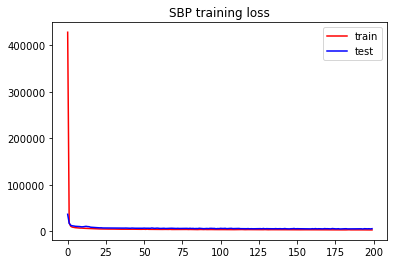

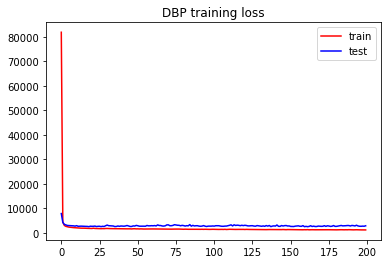

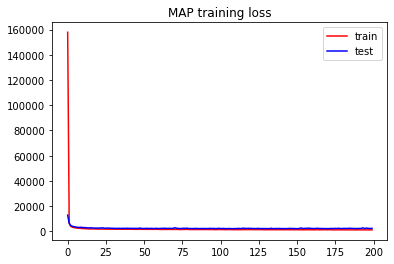

In [25]:
total, ME, MAE, SD = AAMI_standard(DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(MAP_predict, MAP_test)


print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

print('Fully Connected Neural Network')

SBP_cc= np.corrcoef(SBP_predict, SBP_test)
DBP_cc= np.corrcoef(DBP_predict, DBP_test)
MAP_cc= np.corrcoef(MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (MAP_cc[0, 1]))


plt.figure()
plt.title('SBP training loss')
plt.plot(SBP_nn_module.history_train_loss, color='red', label='train')
plt.plot(SBP_nn_module.history_test_loss, color='blue', label='test')
plt.legend()
plt.show()

plt.figure()
plt.title('DBP training loss')
plt.plot(DBP_nn_module.history_train_loss, color='red', label='train')
plt.plot(DBP_nn_module.history_test_loss, color='blue', label='test')
plt.legend()
plt.show()

plt.figure()
plt.title('MAP training loss')
plt.plot(MAP_nn_module.history_train_loss, color='red', label='train')
plt.plot(MAP_nn_module.history_test_loss, color='blue', label='test')
plt.legend()
plt.show()

In [26]:
print(SBP_data)

[127.43 127.43 127.43 ... 144.29 144.29 144.29]


In [27]:
print(DBP_data)



[65.598 65.598 65.598 ... 61.495 61.495 61.495]


In [45]:
print(MAP_data)

[86.20866667 86.20866667 86.20866667 ... 89.09333333 89.09333333
 89.09333333]


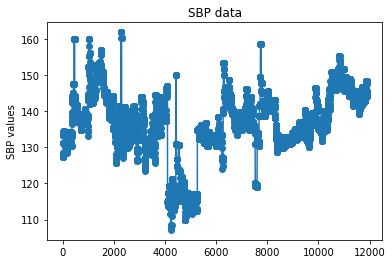

In [46]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(SBP_data, marker='o', linestyle='-')

# Add a title and labels
ax.set_title('SBP data')
ax.set_ylabel('SBP values')

# Show the plot
plt.show()

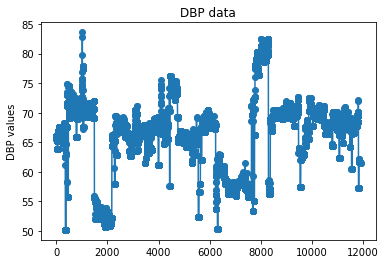

In [34]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(DBP_data, marker='o', linestyle='-')

# Add a title and labels
ax.set_title('DBP data')
ax.set_ylabel('DBP values')

# Show the plot
plt.show()

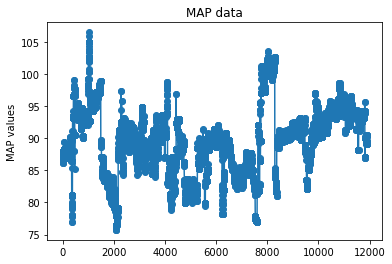

In [49]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(MAP_data, marker='o', linestyle='-')

# Add a title and labels
ax.set_title('MAP data')
ax.set_ylabel('MAP values')

# Show the plot
plt.show()

In [50]:
import pandas as pd


In [56]:
print(len(SBP_data))


11895


In [62]:
#Calculating CVD risk
def calculate_cvd_risk(SBP, DBP, MAP):
    
    cvd_risk = 0.1 * (SBP-DBP) + 0.2 * MAP
    return cvd_risk


CVD_risk = []
for i in range(0, 11895):
    CVD_risk.append(calculate_cvd_risk(SBP_data[i], DBP_data[i], MAP_data[i]))



In [63]:
df = pd.DataFrame({'SBP': SBP_data, 'DBP': DBP_data, 'MAP': MAP_data, 'CVD_risk': CVD_risk})
print(df)

          SBP     DBP        MAP   CVD_risk
0      127.43  65.598  86.208667  23.424933
1      127.43  65.598  86.208667  23.424933
2      127.43  65.598  86.208667  23.424933
3      127.43  66.135  86.566667  23.442833
4      127.43  66.135  86.566667  23.442833
...       ...     ...        ...        ...
11890  144.29  61.495  89.093333  26.098167
11891  144.29  61.495  89.093333  26.098167
11892  144.29  61.495  89.093333  26.098167
11893  144.29  61.495  89.093333  26.098167
11894  144.29  61.495  89.093333  26.098167

[11895 rows x 4 columns]


In [64]:
print(min(CVD_risk))

20.010600000000004


In [65]:
print(max(CVD_risk))

29.258900000000004


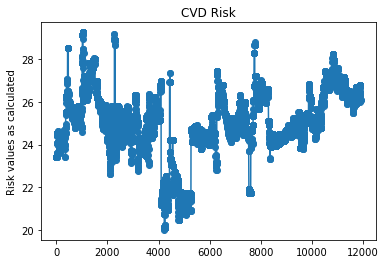

In [71]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(CVD_risk, marker='o', linestyle='-')

# Add a title and labels
ax.set_title('CVD Risk')
ax.set_ylabel('Risk values as calculated')

# Show the plot
plt.show()